<a href="https://colab.research.google.com/github/dan-a-iancu/OIT248/blob/main/Linear_Optimization_Tutorial_Oro_Verde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quick Note on Colab vs. Jupyter
Please run the code here to make sure the Colab file works well. You can also expand and read this briefly.

**The following small segment of code only needs to be run in COLAB. You do not need to worry about running this on your own computer!**

In [1]:
# first install Gurobi, our linear optimization solver
# you do NOT need to do this on your machines, as you already installed Gurobi
!pip install -i https://pypi.gurobi.com gurobipy

# we import a library that allows reading a file from the web (a URL)
import urllib
from urllib import request

# import the Oro_Verde data file from a Github account
url_Q1 = "https://raw.githubusercontent.com/dan-a-iancu/airm/master/Oro_Verde/Oro_Verde_data.csv"
local_file_Q1 = "Oro_Verde_data.csv"   # name of local file where you want to store the downloaded file
aux = urllib.request.urlretrieve(url_Q1, local_file_Q1)    # download from website and save it locally

Looking in indexes: https://pypi.gurobi.com


**If you like COLAB and prefer running our in-class exercises in COLAB rather than Jupyter, here is what you can do:**
 - you can upload the Jupyter Notebook template that is provided with each case using **File > Upload Notebook** (from the Colab **File** menu)
 - to upload any data files that we might be using for a specific case, there are a few options:
   1. From the left sidebar in Colab, choose **Files** (this is to the left of the Table of contents, and it's the fourth icon, which looks like a folder). There, you will have the option to **Upload to session storage**, which will allow you to upload a single file to the current session. Alternatively, you can also select **Mount Drive**, which will allow you to mount your Google drive (which will give you access to all your files there!)
   2. Run one of the snippets of code below, which will essentially complete the steps in (1), depending on what you prefer.

In [2]:
### FIRST OPTION: Upload a file to the local session
#from google.colab import files
#uploaded = files.upload()  # upload a single file from your hard drive

### SECOND OPTION: Mount your Google drive
#from google.colab import drive
#drive.mount('/content/drive')

<a id="intro"></a>
# Expanded Tutorial on Linear Optimization
This Jupyter notebook complements the **Handout on Linear Optimization**, available as a PDF on the course Canvas site. If you are not familiar with the handout, please read the first two sections of the PDF and then return here. This notebook has two related goals:
 1. To show you how to solve the simpler version of the Oro Verde tree planting problem using Python and Gurobi;
 2. To provide several hints for how to construct good models in practice.



The notebook is structured as a broader tutorial and will be a useful reference for future problems.

A small note on the color coding used. We will tend to use <font color=red>**red font for things that are critical**</font>, i.e., things you __have to understand__ to build a model. We will use <font color=blue>**blue font for things that relate to "good practice,"**</font> i.e., that can __make your life easier when building (real-world) models__.
___

Gurobi has its own Python module with several functions that allow you to quickly build an optimization model. Here is an outline of the main steps and associated important Gurobi functions (to navigate to a section, use the **Table of Contents** on the left!)
 - [#1](#params_data) : import data using __pandas__. [`pandas.read_excel(...), pandas.read_csv(...)`]
 - [#2](#create_model) : create an empty __Model__ in Gurobi. [`Model(...)`]
 - [#3](#decisions) : create and add decision variables in the model. [`Model.addVar(...), Model.addVars(...)`]
 - [#4](#objective) : formulate and add an objective in the model. [`quicksum(), Model.setObjective(...)`]
 - [#5](#constraints) : formulate and add constraints in the model. [`Model.addConstr(...)`]
 - [#6](#inspecting_model) : inspect the Gurobi model; [update it](#model_update) and [write it](#write_model) to a file. [ ``Model.update(), Model.write(...)`` ]
 - [#7](#solve) : optimize the model. [`Model.optimize()`]
 - [#8](#printing) : extract the results of the optimization. [`DecisionVariable.X , Model.objVal`]
 - [#9](#evaluating_constraints) : extract information about constraints [`Model.getConstrs(), Model.getRow(...), Expression.getValue(), Constraint.RHS, Constraint.Sense, Constraint.Slack`]
 - [#10](#Gurobi_messages) : output messages in Gurobi
   - a model [solved to optimality](#solved_optimality) [`Model.Status`, `GRB.OPTIMAL`]
   - an [infeasibile](#infeasible) model [`Model.computeIIS(), Constraint.IISConstr`, `GRB.INFEASIBLE`]
  - an [unbounded](#unbounded) model [`GRB.UNBOUNDED, GRB.INF_OR_UNBD`]
 - [#11](#change_model) : sensitivity analysis and shadow prices [`Model.getConstrByName(), Constraint.Pi, Constraint.SARHSLow, Constraint.SARHSUp`]
_______

<a id="basic_model"></a>
The notebook assumes that you are familiar with the Oro Verde case and have understood the optimization model, i.e., the choice of **decision variables** and the expressions for the **objective** and **constraints**. For convenience, here is a formulation of the model taken from the handout :

Find values for the decision variables __${\color{red} M}, {\color{red} E}, {\color{red} S}$__ to: <br>

\begin{align*}
\text{minimize} \qquad & 5.40 \cdot {\color{red} M} + 3.20 \cdot {\color{red} E} + 4.50 \cdot {\color{red} S} &&\text{(cost objective)} \notag \\
\text{subject to} \qquad
& 130 \cdot {\color{red} M} + 3,600 \cdot {\color{red} E} + 400 \cdot {\color{red} S} \leq 150,000 && \text{(land constraint)} ~ (1)\\
& 76 \cdot {\color{red} M} + 48 \cdot {\color{red} E} + 34 \cdot {\color{red} S} \leq 50,000 && \text{(water constraint)} ~ (2)\\
& {\color{red} M} \leq 1,000 && \text{(Maple seedling constraint)} ~ (3)\\
& {\color{red} E} \leq 500 &&  \text{(Elm seedling constraint)} ~ (4)\\
& {\color{red} S} \leq 1,500 && \text{(Spruce seedling constraint)} ~ (5)\\
& {\color{red} E} \geq 15 && \text{(enough Elms constraint)} ~ (6)\\
& 0.70 \cdot 4.3 \cdot {\color{red} M} + 0.60 \cdot 3.7 \cdot {\color{red} E} + 0.80 \cdot 2.80 \cdot {\color{red} S}  \geq 1,800 && \text{(sequestration constraint)} ~ (7)\\
& {\color{red} M} \geq 0\text{, } {\color{red} E} \geq 0 \text{, and } {\color{red} S} \geq 0. && \text{(non-negativity constraints)} ~ (8)
\end{align*}
_______

# Importing modules
First step in any file that builds an optimization model using Gurobi is to include the Gurobi package, through the command line:

In [3]:
# import everything from gurobi
from gurobipy import *

You can also import any other modules that you might need. We will use the _pandas_ module to read in data.

In [4]:
import pandas as pd

________
<a id="params_data"></a>
# #1. Parameters and data

All our models require some data to define the relevant problem parameters. In simple cases, you can directly define some of the parameters by assigning suitable python variable names, as below:

In [5]:
land_avail = 150000              # available land area (in square feet)
water_avail = 50000              # available water (in gallons)
horizon = 10              # start time for commitment (in years)
annual_seq_commit = 1800              # annual sequestration commitment
min_elms = 15   # minimum requirement on elm trees

For larger and more structured data, we will use the `pandas` module to create suitable data frames by reading in csv or xlsx files, as we already learned in class. For instance, we use `read.excel(...)` to read the Excel file and create a data table **that has as index the name of the tree species**.

In [6]:
# create a data frame called "mydata" by reading the sheet called "Data" from an Excel file
mydata = pd.read_csv("Oro_Verde_data.csv", index_col = 0)

# print out the data frame to have a quick look
display(mydata)

,SequestrationRate,WaterRequirement,Width,SurvivalRate,SeedlingCost,SeedlingsAvailable
TreeType,,,,,,
Maple,4.3,76.0,130.0,0.7,5.4,1000.0
Elm,3.7,48.0,3600.0,0.6,3.2,500.0
Spruce,2.8,34.0,400.0,0.8,4.5,1500.0


<font color=red>Choosing to have the index correspond to the tree types is **not coincidental**</font>. **In our optimization model, we have one decision for each tree type, so one decision for every row of the Data Frame we just created**. Having the tree types as the index of the Data Frame will make it extremely convenient to quickly index/search the data based on the tree type, and will also provide a nice name for each decision in the model. In fact, let's create a list with the labels for the rows, i.e., the names of the trees!

In [7]:
tree_types = list(mydata.index)
print(tree_types)

['Maple', 'Elm', 'Spruce']


<font color=blue>**GOOD PRACTICE.** In virtually every linear optimization model, there is a natural relationship between **the data** and **the decisions in your model**. Recall from the PDF tutorial that the objective and all the left- and right-hand sides of constraints in a linear optimization model must be of the form $\sum_{i} C_i \cdot x_i$, where $C_i$ is a coefficient that only depends on data and $x_i$ is a decision. Therefore, **the way the coefficients $C_i$ (or the data needed to obtain them) is stored in the Data Frames can give hints** about (1) a good choice of decision variables in the model and (2) a good way to encode the decisions in Python. For instance, even though the choice of decisions was simple in the Oro Verde case, the data gives you hints for (1): note how to express the cost objective, the coefficients $C_i$ (for seedling cost) are stored as a column of the Data Frame, and similarly, the coefficients needed to express the water or land requirement are stored as the columns **WaterRequirement** and **Width**, respectively. So this suggests that you probably want one decision for each row! As for (2), you will typically encounter one of two cases:</font>
 - <font color=blue> **each row of a Data Frame corresponds to a decision in your problem.** Like here, with Oro Verde. In that case, you should try to see if there is a specific column of data that stores a unique name that you could use to identify the decisions. Almost always, that will be the case and then **you probably want that column of data to become the index (i.e., row labels) for your Data Frame**, which you can do by specifying a suitable `index_col=...` when reading the data into the Data Frame. That is precisely why we used `index_col=0` in the call to `read_excel` above! </font>
 - <font color=blue> **some columns in a DataFrame correspond to some of your decisions.** In that case, you will probably want to create a list with the names of those columns, because they can help identify the corresponding decisions.</font> <br>


______
<a id="create_model"></a>
# #2. Create a Gurobi model

The first step in building our optimization model in Gurobi is to create a Gurobi object that will literally serve as a "placeholder" for all the model ingredients (decision variables, objective, constraints). <font color=red>__To create a new model, use the function ``Model(...)`` found in the Gurobi module,__</font> with the syntax:
> `m = Model(model_name)`

`m` is the Python variable corresponding to the model object that we will need to use henceforth. `modelname` is simply a name that you can give to your model to make more "human interpretable."


In [8]:
mymodel = Model("Simple Tree Planting Model")

Restricted license - for non-production use only - expires 2024-10-28


<font color=blue> __GOOD PRACTICE.__ As we start adding elements into our model, it is a good idea to occasionally inspect it to make sure that everything is OK. This is good __for debugging purposes__, as it allows checking step-by-step whether the changes we intend to make are actually correctly reflected in the Gurobi model. We will show you how to display and check the model ingredients after constructing the entire model, in [Section 6](#inspecting_model). But once you understand those ideas, it might be good to return here and start using those techniques throughout the entire model-building process, rather than waiting until the very end.</font> <br>

_____
<a id="decisions"></a>
# #3. Create and add decision variables
Having constructed an empty Gurobi model, next step is to define and add the decision variables. <br>

## Adding One Variable At a Time
The **simplest** possible way, which we will **not** use very frequently, is to add decision variables one at a time. <font color=red>**To add a single decision variable in a Gurobi model, use the [`addVar`(...)](https://www.gurobi.com/documentation/current/refman/py_model_addvar.html) method of the model**</font>, with syntax:

> `decision_var = Model.addVar ( lb=0.0, ub=float('inf'), obj=0.0, vtype=GRB.CONTINUOUS, name="" )`

Here, `Model` is the Gurobi model object. The function does two things:
 1. It returns a Python object (`decision_var`) that corresponds to the newly created decision variable;
 2. It formally adds this decision variable in our Gurobi model.

All the arguments for the function are optional and have the following meaning:
 - __lb__ : a lower bound on the value of the decision; the default value is 0, so <font color=red>**by omitting a lower bound, Gurobi will automatically add a lower bound of 0, which means it will assume the decision is non-negative**</font>. Most of our models will involve non-negative variables, but if you ever want to make sure that there is no lower bound, use `lb=-float('inf')`
 - __ub__ : an upper bound on the value of the decision; the default value is `float('inf')`, which means $+\infty$ <br>
 - __obj__ : the objective coefficient for the decision variable, i.e., the number that multiplies this decision in the objective
 - __vtype__ : the types of values that the decision can take; we will use __GRB.CONTINUOUS__ for real numbers (i.e., floats), __GRB.INTEGER__ for integers, and __GRB.BINARY__ for decisions that can only take values 0 and 1
 - __name__ : an internal Gurobi name. This it really useful when you try to write the model to a file and visualize/interpret it.

<font color=red>**Specifying lower or upper bounds when defining decision variables is equivalent to adding constraints on the allowable values of the decisions.**</font><br> For instance, `` X = mymodel.addVar( lb=5.0, ub=10.0)`` would create a new decision variable $X$ constrained to satisfy:  $5.0 \leq X \leq 10.0$.

### Applying this in Oro-Verde
In Oro Verde, we have one decision for each tree type ("Maple", "Elm", "Spruce"), that is, one decision for each element of the list `tree_types`. We can define all the decisions with a `for` loop and we will need to store them in some kind of Python structure for future reference. You could use a list for this, but instead we will use a Python dictionary because this is closer to how Gurobi will store things when we define all the decisions at once, so it's useful to start doing it that way!

In [9]:
# we will store the decisions in a dictionary called "trees_to_plant"
trees_to_plant = {}

# define the decisions with a for loop: one for each tree type
for t in tree_types:
    trees_to_plant[t] = mymodel.addVar(lb = 0, name = t)

print(trees_to_plant)

{'Maple': <gurobi.Var *Awaiting Model Update*>, 'Elm': <gurobi.Var *Awaiting Model Update*>, 'Spruce': <gurobi.Var *Awaiting Model Update*>}


__SOME OBSERVATIONS.__

 1. When printing, note that the dictionary has a key corresponding to each tree type and a value saying `<gurobi.Var *Awaiting Model Update*>`. That is because Gurobi does not immediately update your model and it actually awaits for an explicit command to update (see immediately below, in `In[8]`).

 2. Specifying a lower bound of 0 (`lb = 0`) for each decision means that we effectively added all the non-negativity constraints from [our model](#basic_model), i.e., constraints (8). Since no upper bound was included, Gurobi will default to `ub` $=+\infty$.<br>

 3. We did not include an objective coefficient. Instead, we will calculate and add the objective in the next step, which is what you typically need to do in complex models, where it's hard to know the objective coefficients apriori. (In the simple Oro Verde model, we could have specified the objective coefficients directly as `mydata.loc[t,"SeedlingCost"]`.)

 4. Our choice of Gurobi names was __"Maple," "Elm", "Spruce"__ rather than **M, E, S** as in the [model formulation](#basic_model). (If you really want to have the names **M,E,S**, you can change the syntax to: `name = t[0]`.)

Gurobi automatically updates your model when it solves it, but <font color=red>to force Gurobi to update the model while you construct it (so that you can inspect it), you can use the `update` method</font>, as below.

In [10]:
# force Gurobi to update the model
mymodel.update()

# print the model
print(mymodel)

<gurobi.Model Continuous instance Simple Tree Planting Model: 0 constrs, 3 vars, No parameter changes>


Note that this does not actually give a lot of useful information: it just says that there are 3 variables. As we add elements, it will become more useful.

For now, because we will actually add the decision variables again with the second method below, we remove them. (If we did not remove them, we would end up having duplicate variables in Gurobi - this is not a tragedy, and the model should still run correctly, but it's cleanest to just remove them before adding again.) **To remove a variable, you can use the `remove` method**, as below.

In [11]:
# loop through all the tree types
for t in tree_types:
    mymodel.remove(trees_to_plant[t])  # remove each decision variable

# force Gurobi to update the model
mymodel.update()

# print the model
print(mymodel)

<gurobi.Model Continuous instance Simple Tree Planting Model: 0 constrs, 0 vars, No parameter changes>


## Adding All Variables In One Shot
Because our models almost always involve many decisions, the **most efficient** way is to add several decision variables in one shot. The most general case is when we have **one or more** Python lists and we want decisions corresponding to every combination (i.e., cross product) of elements from those lists.

<font color=red>**If we have lists stored in the Python variables `list_1`, `list_2`, ..., `list_n`, to add a decision variable for every cross product from these lists, use the [`addVars`(...)](https://www.gurobi.com/documentation/current/refman/py_model_addvars.html) method of the model**</font>, with syntax:

> `dictionary_of_decisions = Model.addVars( list_1, list_2, ..., list_n, lb=0.0, ub=float('inf'), obj=0.0, vtype=GRB.CONTINUOUS, name="" )`

This adds all the decision variables in the Gurobi model `Model` and returns a **dictionary** `dictionary_of_decisions` that contains all the newly created decision variables. This dictionary has **keys** corresponding to every tuple of the form `(v1,v2,...,vn)` where `v1` is any element from `list_1`, `v2` is any element from `list_2`, etc. You can access any decision using the syntax <br>
  > `dictionary_of_decisions[(v1,v2,...,vn)]`
  
The other arguments for `addVars` have the same meaning as for `addVar`. However, these could take several forms here:
 - If you provide a **scalar** value (or use the default) for `lb`, `ub` or `obj`, then that will apply for every variable. For example, lb=1.0 will give every created decision variable a lower bound of 1.0. Using a scalar for `name` is a bit different: this will be used as a prefix and the rest of the name will be derived in the form "[v1,v2,...,vn]" where `v1` is any element from `list_1`, `v2` is any element from `list_2`, etc.
 - If you provide a Python **dictionary** as the argument, that dictionary should have exactly the same keys as `dictionary_of_decisions` (i.e., every tuple of the form `(v1,v2,...,vn)` where `v1` is any element from `list_1`, `v2` is any element from `list_2`, etc.) and values corresponding to the desired argument, i.e., lower bounds, upper bounds, objective coefficients, or names.

___
It might be best to consider a simple example here. Imagine we have a list of names:
> `list_1 = ["John", "Mary", "Charles"]`

and we also have a list of different companies whose stock could be bought:
> `list_2 = ["Apple", "Microsoft", "Google", "Tesla", "Pepsi"]`

and we want decisions for every pair of the form (name, company) corresponding to how many stocks the respective name holds for the respective company. Let's create a "mock" Gurobi model so that we don't inadvertently change our Oro Verde model, add these decisions, and print them.

In [12]:
# create a mock model
silly_model = Model("Stock example with many lists")

# define all the decision variables
stock_holdings = silly_model.addVars(["John", "Mary", "Charles"], ["Apple", "Microsoft", "Google", "Tesla", "Pepsi"], \
                                     name="stocks")

# print them
print(stock_holdings)

{('John', 'Apple'): <gurobi.Var *Awaiting Model Update*>, ('John', 'Microsoft'): <gurobi.Var *Awaiting Model Update*>, ('John', 'Google'): <gurobi.Var *Awaiting Model Update*>, ('John', 'Tesla'): <gurobi.Var *Awaiting Model Update*>, ('John', 'Pepsi'): <gurobi.Var *Awaiting Model Update*>, ('Mary', 'Apple'): <gurobi.Var *Awaiting Model Update*>, ('Mary', 'Microsoft'): <gurobi.Var *Awaiting Model Update*>, ('Mary', 'Google'): <gurobi.Var *Awaiting Model Update*>, ('Mary', 'Tesla'): <gurobi.Var *Awaiting Model Update*>, ('Mary', 'Pepsi'): <gurobi.Var *Awaiting Model Update*>, ('Charles', 'Apple'): <gurobi.Var *Awaiting Model Update*>, ('Charles', 'Microsoft'): <gurobi.Var *Awaiting Model Update*>, ('Charles', 'Google'): <gurobi.Var *Awaiting Model Update*>, ('Charles', 'Tesla'): <gurobi.Var *Awaiting Model Update*>, ('Charles', 'Pepsi'): <gurobi.Var *Awaiting Model Update*>}


Note how we have a decision for every pair, and the keys in the dictionary are tuples. However, you cannot see the **names** that we defined! The only place where you will see those names is when you [write it to a file](#write_model).

____
### Applying this in Oro-Verde
In Oro Verde, we have one decision for every element of the list `tree_types`, which we can add very easily in one shot:

In [13]:
# add one decision for each element of the list 'tree_types' and return the dictionary
trees_to_plant = mymodel.addVars(tree_types, lb = 0, name=tree_types)

# print the dictionary to see
print(trees_to_plant)

{'Maple': <gurobi.Var *Awaiting Model Update*>, 'Elm': <gurobi.Var *Awaiting Model Update*>, 'Spruce': <gurobi.Var *Awaiting Model Update*>}


Note that we specified as name for our decision variables exactly the list `tree_types`, which means the names will be "Maple", "Elm", "Spruce". You can see this in Section 6, when we [write the model to a file](#write_model) to inspect it. You can feel free to experiment with adding a different prefix for the name above and checking the effect in Section 6. (For instance, using `name="plant"` above would result in the names `plant[Maple], plant[Elm], plant[Spruce]`.)

____________
<a id="objective"></a>
# #4. Formulate and add the objective

We need to construct an expression for the objective. We will store this in a new python variable, which we call ``planting_cost``. There are many ways to construct the correct expression. For instance, we could just rely on a plain ``for`` loop, as in:

> `planting_cost = 0.0` <br>
> `for t in tree_types : `<br>
>  $\qquad$     `planting_cost += trees_to_plant[t] * mydata.loc[t]["SeedlingCost"]`

Instead, we will use the Gurobi __quicksum(...)__ function, which is very similar to Python's traditional __sum(...)__ function but is more efficient when summing over decision variables. <font color=red>__We will use this often in our class, so make sure you understand how it works!__</font>

In [14]:
# calculate the cost with Gurobi's quicksum(.) function
planting_cost = quicksum(trees_to_plant[t] * mydata.loc[t,"SeedlingCost"] for t in tree_types)

If you force Gurobi to update the model (using `.update()`), you can even print the expression for the objective with a regular print function. This will allow you to see what this expression looks like in Gurobi, using the variable names that you defined.

In [15]:
# force Gurobi to update (just so that we can see things later)
mymodel.update()

# print the expression for the objective
print(planting_cost)

5.4 Maple + 3.2 Elm + 4.5 Spruce


<font color=red>**To add the objective inside a Gurobi model, use the `setObjective(...)` method of the model.**
</font> The syntax is:

> ``Model.setObjective ( expression, sense )``

The arguments have a straightforward meaning:
 - __expression__ : the expression for the objective (this could also just be a python variable containing the expression)
 - __sense__ : the "sense" in which to optimize; two options are possible, __GRB.MAXIMIZE__ or __GRB.MINIMIZE__

In [16]:
# set the objective in our Gurobi model
mymodel.setObjective(planting_cost, GRB.MINIMIZE)

________
<a id="constraints"></a>
# #5. Formulate and add the constraints

We will add the constraints one at a time for clarity.
<font color=red>
__To add one constraint, use the `addConstr(...)` method of the model.__
</font> The typical syntax can take two forms:
> `con = Model.addConstr ( lhs, sense=None, rhs=None, name="" )` <br>
> `con = Model.addConstr ( expression, name="" )`

This returns the constraint in the object `con`. The meaning of the arguments is :
 - __lhs__ : the left-hand-side of the constraint
 - __sense__ : the type of the constraint (">=" or "=" or "<=")
 - __rhs__ : the right-hand-side of the constraint
 - __expression__ : a full expression of the constraint that includes the left-hand-side, the sense, and the right-hand-side
 - __name__ : a Gurobi name for the constraint

The first syntax above is a more detailed one, where we can specify separately each ingredient of the constraint. The second syntax is more compact, and we will be using it more frequently. But these two are clearly equivalent, meaning that every correct specification of a constraint must include all three elements: left-hand-side, sense, and right-hand-side. For more details, see the [Gurobi manual](https://www.gurobi.com/documentation/10.0/refman/cs_model_addconstr.html).

<font color=blue>**GOOD PRACTICE**. Two small observations here. <br>
(1) There are many ways to express the same constraint logic, e.g., $a \leq b$ is the same as $b \geq a$ or $a - b \leq 0$ or $b-a \geq 0$. We recommend adding constraints so that __the right-hand-side is a problem parameter / data__. This gives each constraint a more clear physical interpretation, and will be helpful later when we discuss sensitivity analysis.<br>
(2) We suggest storing each constraint in some Python data structure (e.g., in a dictionary) so that you can refer to it easily later if you need to. </font>

In [17]:
# a dictionary where we will store all the constraints
all_constr = {}

#### Constraint 1: land availability
Below, we first create the constraint in a variable `con` and then add it to our dictionary. You can obviously do this with just a single instruction. (We saved the separate variable `con` because we need to use it afterwards, a few times.)

In [18]:
# create the constraint
con = mymodel.addConstr( quicksum(trees_to_plant[t] * mydata.loc[t,"Width"] \
                                  for t in tree_types) <= land_avail , "land_avail" )

# add it to the dictionary
all_constr["land_avail"] = con

Just as with the objective, if you force Gurobi to update the model (using `.update()`), you can actually check what the expression for a constraint looks like, which is very useful for debugging purposes.

<font color=red>**After updating the model, you can obtain useful information about a specific constraint. For a constraint `con` from model `model`, you can obtain all the relevant attributes as follows:**</font>
  - <font color=red>to get the **expression of the constraint left-hand-side**, use `model.getRow(con)`</font>
  - <font color=red>to get the **sense**, use `con.Sense`  </font>
  - <font color=red>to get its Gurobi **name**, use `con.ConstrName` </font>
  - <font color=red>to get the **constraint right-hand-side**, use `con.RHS`</font>
  
<font color=red>All of the attributes above are actually **not** case-sensitive, so, e.g., `sense` and `Sense` both work!</font>

In [19]:
# force Gurobi to update
mymodel.update()

# now let's print some information about the constraint
print(f"Constraint name : {con.ConstrName}\n {mymodel.getRow(con)} {con.Sense} {con.RHS}")

Constraint name : land_avail
 130.0 Maple + 3600.0 Elm + 400.0 Spruce < 150000.0


#### Constraint 2: water availability

In [20]:
con = mymodel.addConstr( quicksum( trees_to_plant[t] * mydata.loc[t,"WaterRequirement"] \
                                  for t in tree_types) <= water_avail, "water_avail" )
all_constr["water_avail"] = con

# force Gurobi to update so we can print this one, too
mymodel.update()

# now let's print some information about the constraint
print(f"Constraint name : {con.ConstrName}\n {mymodel.getRow(con)} {con.Sense} {con.RHS}")

Constraint name : water_avail
 76.0 Maple + 48.0 Elm + 34.0 Spruce < 50000.0


#### Constraints 3-5: seedling availability for each tree type

In [21]:
# one constraint for each tree type
for t in tree_types:
    constr_name = f"{t}_seedlings"  # set up a good name for the constraint, using the tree type
    all_constr[constr_name] = mymodel.addConstr( trees_to_plant[t] <= mydata.loc[t,"SeedlingsAvailable"], constr_name )

#### Constraint 6: minimum number of elm trees

In [22]:
# we should plant at least some minimum number of Elm trees
all_constr["min_elms"] = mymodel.addConstr( trees_to_plant["Elm"] >= min_elms, "min_elms" )

#### Constraint 7: minimum carbon sequestration commitment

In [23]:
all_constr["carbon_seq"] = mymodel.addConstr( quicksum( trees_to_plant[t] * mydata.loc[t,"SurvivalRate"] * \
                                                       mydata.loc[t,"SequestrationRate"]  for t in tree_types ) \
                                             >= annual_seq_commit , "carbon_seq")

Let's print our dictionary of constraints, to see what it looks like.

In [24]:
print(all_constr)

{'land_avail': <gurobi.Constr land_avail>, 'water_avail': <gurobi.Constr water_avail>, 'Maple_seedlings': <gurobi.Constr *Awaiting Model Update*>, 'Elm_seedlings': <gurobi.Constr *Awaiting Model Update*>, 'Spruce_seedlings': <gurobi.Constr *Awaiting Model Update*>, 'min_elms': <gurobi.Constr *Awaiting Model Update*>, 'carbon_seq': <gurobi.Constr *Awaiting Model Update*>}


<a id="inspecting_model"></a>
# #6. Inspect the model

<font color=blue> __GOOD PRACTICE.__ Now that we have added all the ingredients, __it is quite critical to check the model and make sure it is actually correct.__</font>

One way to do this is simply to __print the model__. Here is the output we would get by printing right now:

In [25]:
mymodel

<gurobi.Model Continuous instance Simple Tree Planting Model: 2 constrs, 3 vars, No parameter changes>

This might seem like a mistake: the model still looks "empty," although we just added everything! But **this is not an error**! It is related to Gurobi's 'lazy updating' feature, which means that Gurobi will not process any updates to the model until we run some specific commands that force it to do that. There are three methods that do this, and we will talk about each subsequently. These are:
 - the __update()__ method : as the name says, this simply updates the model
 - the __write(...)__ method : this writes the model to a file
 - the __optimize()__ method : this solves the model

<a id="model_update"></a>
### Update the model

To update a Gurobi model so it reflects all the changes made (with no additional action), run the __update()__ method.

In [26]:
# force Gurobi to update the model
mymodel.update()

# print the model
print(mymodel)

<gurobi.Model Continuous instance Simple Tree Planting Model: 7 constrs, 3 vars, No parameter changes>


Gurobi now correctly recognizes and displays that our model has 3 variables and 7 constraints. But beyond that, this output is not terribly useful for finding __errors__ in the model...

<a id="write_model"></a>
### Write the model for inspection

Perhaps the best way to visualize and "debug" our model is to write it to a file using a special (LP) format, which is designed to output optimization models in a "human-readable" form. (As a side note, this process will also update your model to reflect any pending changes!) Here is how this works.

In [27]:
# write the model to a file with extension ".lp"
mymodel.write("my_model.lp")

Now you can open this file with any text viewer and read it. Alternatively, the code below reads it and prints it in Jupyter, to save you the trouble...

In [28]:
# open a file handle
f = open("my_model.lp", 'r')

# read the contents and print them
print( f.read() )

# close the file handle
f.close()

\ Model Simple Tree Planting Model
\ LP format - for model browsing. Use MPS format to capture full model detail.
Minimize
  5.4 Maple + 3.2 Elm + 4.5 Spruce
Subject To
 land_avail: 130 Maple + 3600 Elm + 400 Spruce <= 150000
 water_avail: 76 Maple + 48 Elm + 34 Spruce <= 50000
 Maple_seedlings: Maple <= 1000
 Elm_seedlings: Elm <= 500
 Spruce_seedlings: Spruce <= 1500
 min_elms: Elm >= 15
 carbon_seq: 3.01 Maple + 2.22 Elm + 2.24 Spruce >= 1800
Bounds
End



This output should look similar to our basic model formulation in [the introduction](#basic_model). The only differences are the decision variable names (__Maple__, __Elm__ and __Spruce__ instead of __M__, __E__ and __S__) and that the LP model does not include the non-negativity constraints (8) explicitly. The latter happens because these were added as bounds on the decision variables in [Step 3](#decisions). You may notice that these (non-negativity) bounds also do not appear in the ``Bounds`` portion of the output above; this is by design, since non-negativity is assumed by default in the LP format. In other words, __an LP model always includes the constraints "__``decisions >= 0``__" by default, and does not display them__. For more details on the LP format, you can refer to the [Gurobi manual](https://www.gurobi.com/documentation/10.0/refman/lp_format.html).

<font color=blue> __GOOD PRACTICE.__ If we detect a mistake when inspecting the model, the cleanest way to proceed would be to restart the entire notebook, by clicking the __Kernel__ button in Jupyter and selecting  __Restart__. This allows revisiting each step of the process to identify and fix the mistake(s). This is also why __it is very helpful to print out the model at intermediate steps__, so that we do not wait until the very end to identify potential issues! </font>

As a side note, in very large models, it may be too costly to rerun the entire notebook/process. Gurobi has functionality that allows changing a model by removing constraints or decision variables, using the `remove` function -- just like we did in `In[8]`, when we remove the three decision variables. But we do not advocate using this as a procedure to fix mistakes, because your notebook would essentially always first _make_ mistakes and then _fix_ them...

____
<a id="solve"></a>
# #7. Optimize the model

<font color=red>**To solve/optimize our Gurobi model, use the `optimize()` method of the model object.**</font><br>
(__Note:__ This function also updates your model to reflect any pending changes.)

In [29]:
# solve the model to optimality
mymodel.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 7 rows, 3 columns and 13 nonzeros
Model fingerprint: 0x017ecc2f
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [3e+00, 5e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 2e+05]
Presolve removed 4 rows and 0 columns
Presolve time: 0.02s
Presolved: 3 rows, 3 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1965890e+03   1.154615e+03   0.000000e+00      0s
       1    3.2130952e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.03 seconds (0.00 work units)
Optimal objective  3.213095170e+03


**If everything is OK, Gurobi should stop and report a finite value "Optimal objective" on the last line above.** We will discuss other potential messages you might encounter here in a separate section on [Gurobi output messages](#Gurobi_messages).

____
<a id="printing"></a>
# #8. Extract the optimized results

Once Gurobi has finished optimizing the model, we will likely want to extract some information concerning the solution and its properties. (**IMPORTANT! The functions here can only be used _after_ Gurobi is done optimizing!**)

<font color=red> __We can recover the optimal value of a decision variable using its .X attribute.__</font><br>
We print the optimal solution here with a _for loop_, but depending on the (size of your) model, you may want to do this differently.

In [30]:
# print solution with a for loop
print("Optimal solution is to plant:")
for t in tree_types :
    print(f"{t:10s} : {trees_to_plant[t].X:.2f}")

Optimal solution is to plant:
Maple      : 582.80
Elm        : 20.62
Spruce     : 0.00


Note that the optimal solution involves fractional values, e.g., 582.80 Maple trees. Because we allowed Gurobi to use continuous variables, this is natural. If we really needed the solutions to be **integral**, we should have specified this when defining the variables. However, as we will learn later on in the course, integrality makes the optimization problems **a lot harder to solve**, so whenever this is not critical, it is best to avoid it.

<font color=red> __We can recover the optimal objective value in the model using the __.objVal__ attribute.__ </font>

In [31]:
# print the value of the objective
print(f"Optimal cost is: ${mymodel.objVal:.3f}")

Optimal cost is: $3213.095


____
<a id="evaluating_constraints"></a>
# #9. Extract information on constraints

#### Printing useful information/attributes:
Once we solve the model, it is very useful to extract information for each constraint. For instance, you may wonder which constraints are **binding**, i.e., hold with equality at the optimal solution. (Intuitively, these are the "important" constraints in the model.)

Recall from our earlier discussion that for a constraint `con` from model `model`, you can use the following approach to recover important information:
 - __model.getRow(con)__ : the expression of the constraint left-hand-side
 - __con.ConstrName__  : the name specified when defining the constraint
 - __con.RHS__    : the value of the right-hand-side of the constraint
 - __con.Sense__ : the type of constraint ( <= or = or >= )
 - __con.Slack__  : (value of right-hand-side) - (value of left-hand-side), available after Gurobi finished optimizing.


<font color=red>**IMPORTANT!** If the left-hand-side or right-hand-side of a constraint is an expression of Gurobi decision variables, then printing it would simply print out the formula/expression, just like in `In[17]` (when we printed the constraint when adding it to the model). **To find out __the value__ of the LHS/RHS evaluated at the optimal solution, you need to use the `getValue()` method.**
    
To appreciate this point, let's collect the left-hand-side of the water availability constraint. We can use the name `water_avail` to recover this constraint from our dictionary and then use `model.getRow(.)` to get its LHS.

In [32]:
# get the water availability constraint from the dictionary using its name
water_avail_con = all_constr["water_avail"]

# get the LHS of the constraint
LHS_water = mymodel.getRow(water_avail_con)

# now let's print the LHS as is
print(LHS_water)

# instead, we now **evaluate** the expression for the LHS using the getValue() method
print(LHS_water.getValue())

76.0 Maple + 48.0 Elm + 34.0 Spruce
45282.43927413391


#### Getting access to all the constraints
We already saved all the constraints in a nice dictionary. However, if you forget to do that and want to obtain a list of all the linear constraints in your model, you can use the **`getConstrs()`** method:

In [33]:
allConstraints = mymodel.getConstrs()
print(allConstraints)

[<gurobi.Constr land_avail>, <gurobi.Constr water_avail>, <gurobi.Constr Maple_seedlings>, <gurobi.Constr Elm_seedlings>, <gurobi.Constr Spruce_seedlings>, <gurobi.Constr min_elms>, <gurobi.Constr carbon_seq>]


Let's use all of the above to print out useful information about all the constraints.

In [34]:
# Below, we create a nice data-frame to print useful information about constraints
# we'll store all the data in a list of lists (!):
#  - the outer list contains one list for each constraint
#  - the inner list (for a given constraint) has the name, value of the LHS, RHS, sense and slack
all_constr_data = [ [c.ConstrName, mymodel.getRow(c).getValue(), c.Sense, c.RHS, c.Slack] for c in allConstraints ]

# convert into a dataframe and print
df = pd.DataFrame(all_constr_data, columns=["Constraint Name", "LHS Value", "Sense", "RHS Value", "Slack"])
display(df)

,Constraint Name,LHS Value,Sense,RHS Value,Slack
0,land_avail,150000.000000,<,150000.0,0.000000
1,water_avail,45282.439274,<,50000.0,4717.560726
2,Maple_seedlings,582.797656,<,1000.0,417.202344
3,Elm_seedlings,20.621196,<,500.0,479.378804
4,Spruce_seedlings,0.000000,<,1500.0,1500.000000
5,min_elms,20.621196,>,15.0,-5.621196
6,carbon_seq,1800.000000,>,1800.0,0.000000


The constraints with **Slack=0** are the **binding constraints** (and all the other ones are non-binding).

_____
<a id="Gurobi_messages"></a>
# #10. Output messages in Gurobi.
You may encounter several types of messages in Gurobi, depending on what happens in your optimization model. We briefly survey some of the most common ones here.

<a id="solved_optimality"></a>
## Model solved to optimality
When everything is "alright" and Gurobi is able to solve your model to optimality, the output should look like like what we got after `In[27]`: it should report finding an **Optimal objective** with a finite value on the last line.

**IMPORTANT!** Sometimes, you want to determine programatically whether Gurobi was able to solve a model to optimality (e.g., imagine you are solving many versions of the same model, with different parameters!) We can check whether Gurobi successfully solved a model to optimality using the model's `status` attribute. This can take several values (details [here](https://www.gurobi.com/documentation/current/refman/optimization_status_codes.html)); when optimality is achieved, the status should be **GRB.OPTIMAL**.

Let's solve our base model one more time and print its status!

In [35]:
# solve the model
mymodel.optimize()

# print the status
print(f"\n\nThe optimality status is: {mymodel.status}. If optimal, the status should be {GRB.OPTIMAL}.")

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 7 rows, 3 columns and 13 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [3e+00, 5e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 2e+05]

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.213095170e+03


The optimality status is: 2. If optimal, the status should be 2.


<a id="infeasible"></a>
## Infeasible model

As it turns out, if we required planting at least 1000 Elms (instead of just 15), the model would become __infeasible__, i.e., it would be impossible to find values for __M__, __E__ and __S__ to satisfy all the constraints. Let us see what happens in Gurobi when this is the case.

In [36]:
# recall what the constraint for Elm trees was originally -- let's print it here quickly
c = all_constr["min_elms"]
print(f'Original constraint for Elms:\n {c.ConstrName:} \t {mymodel.getRow(c)} {c.Sense} {c.RHS} \n')

# let's CHANGE the constraint - we can do that with the setAttr(.) function
c.RHS = 1000

# force Gurobi to update
mymodel.update()

# print again to see the change
print(f'New constraint for Elms:\n {c.ConstrName:} \t {mymodel.getRow(c)} {c.Sense} {c.RHS} \n')

# solve the new model
mymodel.optimize()

# print the status
print(f"\n\nThe optimality status is: {mymodel.status}. If infeasible, the status should be {GRB.INFEASIBLE}.")

Original constraint for Elms:
 min_elms 	 Elm > 15.0 

New constraint for Elms:
 min_elms 	 Elm > 1000.0 

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 7 rows, 3 columns and 13 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [3e+00, 5e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+02, 2e+05]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.2130952e+03   6.268024e+04   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds (0.00 work units)
Infeasible model


The optimality status is: 3. If infeasible, the status should be 3.


Note the last few lines: Gurobi now reports __"Infeasible model"__, and when we print the optimality status 3, which exactly corresponds to **GRB.INFEASIBLE**.

### How to resolve infeasibilities?

<font color=blue> In a real-world model, we may not know where the infeasibilities are coming from. For instance, our model could contain a very large number of constraints and it may be hard to guess apriori which the culprits are. To narrow things down, it is very useful **to isolate a small set of constraints that taken together already make the model infeasible. We can do this using the model's `IIS()`** method, which stands for "irreducible inconsistent subsystem". This is a set of $n$ constraints with two important properties: </font>
 - <font color=blue> these $n$ constraints alone are impossible to satisfy </font>
 - <font color=blue> removing one of the constraints leaves the other $n-1$ constraints feasible </font>

In [37]:
# compute the IIS
mymodel.computeIIS()


IIS computed: 2 constraints and 0 bounds
IIS runtime: 0.00 seconds (0.00 work units)


According to this output, there is an IIS consisting of 2 constraints. To get more details, the easiest way is to write the model to an __ILP__ file. This file format is specifically designed to display IIS information, and is as easy to read/interpret as the __LP__ format we saw earlier. Here is how this would work.

In [38]:
# write model information to an .ilp file
mymodel.write("output_infeasible.ilp")

# open a file handle
f = open("output_infeasible.ilp", 'r')

# read the contents and print them
print( f.read() )

# close the file handle
f.close()

\ Model Simple Tree Planting Model_copy
\ LP format - for model browsing. Use MPS format to capture full model detail.
Minimize
 
Subject To
 Elm_seedlings: Elm <= 500
 min_elms: Elm >= 1000
Bounds
 Elm free
End



According to the output above, the 2 problematic constraints are '__Elm_seedling_avail__' and '__min_elms__'. In practice, this information would then allow you to revisit the constraints and think of ways to "relax" or change them.

<font color=blue>**Good practice.** In models with lots of decisions, it may be hard to read things from the file. So alternatively, instead of printing the IIS to the file, you can obtain extra information about the constraints included in the IIS system using the `IISConstr` attribute. The following code shows how you can (i) print the entire set of constraints, highlighting the ones that are in the IIS, and (ii) print just the constraints in the IIS system.</font>

In [39]:
# Create a nice data-frame to print useful information about constraints
allConstraints = mymodel.getConstrs()
all_constr_data = [ [c.ConstrName, mymodel.getRow(c).getValue(), c.Sense, \
                     c.RHS, c.Slack, c.IISConstr] for c in allConstraints ]

# convert into a dataframe and print
df = pd.DataFrame(all_constr_data, columns=["Constraint Name", "LHS Value", \
                                            "Sense", "RHS Value", "Slack", "IIS"])
print("Information on ALL the constraints. Last column shows which are in IIS.")
display(df)

# if you want, you can display ONLY the constraints in the IIS system
print("Printing ONLY the constraints in the IIS subsystem.")
display(df[df["IIS"]==1])

Information on ALL the constraints. Last column shows which are in IIS.


,Constraint Name,LHS Value,Sense,RHS Value,Slack,IIS
0,land_avail,92.112082,<,150000.0,0.000000,0
1,water_avail,347.969346,<,50000.0,4717.560726,0
2,Maple_seedlings,582.797656,<,1000.0,417.202344,0
3,Elm_seedlings,20.621196,<,500.0,479.378804,1
4,Spruce_seedlings,0.000000,<,1500.0,1500.000000,0
5,min_elms,20.621196,>,1000.0,979.378804,1
6,carbon_seq,441.416427,>,1800.0,0.000000,0


Printing ONLY the constraints in the IIS subsystem.


,Constraint Name,LHS Value,Sense,RHS Value,Slack,IIS
3,Elm_seedlings,20.621196,<,500.0,479.378804,1
5,min_elms,20.621196,>,1000.0,979.378804,1


Let's revert back the min_elms constraint so that we return the model to its original form.

In [40]:
# recall what the constraint for Elm trees was originally -- let's print it here quickly
c = all_constr["min_elms"]
c.RHS = min_elms

# force Gurobi to update
mymodel.update()

<a id="unbounded"></a>
## Unbounded model
In some cases, you may see a message from Gurobi that the movel is **Infeasible or unbounded**. First, let's understand how that could happen. Imagine that in our mode, we remove the carbon sequestration constraint and we allow the Maple decision to take negative values. (This is, of course, a silly example because it's not clear what the means physically...) But mathematically, it so happens that this means the model could continue to decrease the number of Maple trees to $-\infty$ and thus obtain a cost of $-\infty$ (the best cost you could ever hope for...)

In [41]:
# remove the carbon sequestration constraint
mymodel.remove(all_constr["carbon_seq"])

# allow the Maple decision to take negative values: we do this by changing the lower bound from 0 to -$\infty$
trees_to_plant["Maple"].setAttr("LB", -GRB.INFINITY)

# solve the new model
mymodel.optimize()

# also print the optimality status
print(f"\n\nThe optimality status is: {mymodel.status}. If unbounded or infeasible, status should be {GRB.INF_OR_UNBD}. If unbounded, status should be {GRB.UNBOUNDED}.")

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 6 rows, 3 columns and 10 nonzeros
Model fingerprint: 0x960b6889
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [3e+00, 5e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 2e+05]
Presolve time: 0.01s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Infeasible or unbounded model


The optimality status is: 4. If unbounded or infeasible, status should be 4. If unbounded, status should be 5.


The last line identifies the model as being **Infeasible or unbounded.** (If you need a more definitive answer, you will need to set the **DualReductions** parameter to 0 and reoptimize; see below for details.) Real-world models should never be unbounded, so if you ever encouter this, it likely means that either you forgot to include all the relevant constraints or you included them erroneously.

To disambiguate when you are getting this **infeasible or unbounded** error, you should use the following code:

In [42]:
# set the dual reductions parameter to 0
mymodel.setParam('DualReductions', 0)

# reset the optimal status of the model
mymodel.reset()

# resolve
mymodel.optimize()

Set parameter DualReductions to value 0
Discarded solution information
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 6 rows, 3 columns and 10 nonzeros
Model fingerprint: 0x960b6889
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [3e+00, 5e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 2e+05]
Presolve time: 0.01s
Presolved: 2 rows, 3 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3500000e+30   0.000000e+00   1.350000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Unbounded model


Note that above, we are now getting a report that the model is really unbounded.

Let's reverse the changes that we made! Let's add back the constraint on carbon sequestration and the lower bound on Maple trees.

In [43]:
# add the constraint back
all_constr["carbon_seq"] = mymodel.addConstr( quicksum( trees_to_plant[t] * mydata.loc[t,"SurvivalRate"] * \
                                                       mydata.loc[t,"SequestrationRate"]  for t in tree_types ) \
                                             >= annual_seq_commit , "carbon_seq")

# reset the lower bound
trees_to_plant["Maple"].setAttr("LB", 0)

# update the model
mymodel.update()

_____
<a id="change_model"></a>
# #11. Sensivity Analysis & Shadow Prices

The parameters / data in a problem are almost always imprecise, e.g., they are often estimated through some statistical procedure. It is therefore critical to understand how the results of the optimization would change when the data changes. This is known as __sensitivity analysis__, and is a critical step in understanding the model outputs and generating credible recommendations. More importantly though, this also allows calculating **shadow prices** for various resources or constraints in the system, which allows quantifying their ($) impact on the model. This is critically important and we'll discuss some real-world examples in class that leverage this for various pricing tasks. To illustrate the concepts, consider the following motivating question:

<font color=blue>_Suppose that Oro Verde is considering changing its commitment for carbon sequestration: instead of 1,800, they are considering values from 1,500 to 2,100. We would like to know how Oro Verde's optimal costs would change when this commitment changes._</font>

#### Doing Sensitivity "Manually"
In some cases, it's most useful to do sensitivity manually, by changing parameters and resolving the model. The following code shows how to do that when changes occur in a constraint right-hand-side.

__Step 1.__ We start by creating a list of all the values that we want to test. We could manually construct a list with these values, but it is easier to rely on a python function called `arange` found in the `numpy` package. You can read more about it in [this documentation page](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.arange.html). This is similar - but more general - then the familiar `range` function. Its syntax is :
 > `arange(init_value, final_value, step)`

where `init_value, final_value` and `step` can all be float values, i.e., they do not have to be integers. This returns the list of all values between `init_value` and `final_value` in increments of size `step`. __(Similar to `range`, this list includes `init_value` but excludes `final_value`.)__

In [44]:
from numpy import arange   # import the function `arange` from the numpy package

carbon_seq_values = list(arange(1600,2050,50))  # we use 21500 instead of 2100 so as to include the latter in the list
print(carbon_seq_values)

[1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000]


__Step 2.__ We need to obtain a handle on the constraint that we want to change. We already have our handy dictionary that allows doing that using the constraint name. (If you do not have a dictionary, you can use the method `getConstrByName` from the model, which allows recovering a constraint using its name.)

In [45]:
# recover the constraint with the name
c = all_constr["carbon_seq"]

print(f'New constraint for CO2 seq:\n {c.ConstrName:} \t {mymodel.getRow(c)} {c.Sense} {c.RHS} \n')

New constraint for CO2 seq:
 carbon_seq 	 3.01 Maple + 2.22 Elm + 2.2399999999999998 Spruce > 1800.0 



__Step 3.__ Within a `for` loop, change the constraint right-hand-side using the `setAttr` method, resolve the model, and store the objective.

In [46]:
# an empty list where we will store the values of the objective
all_cost_values = []

# set a flag to determine whether to run Gurobi silently
run_silently = False
if run_silently:
    mymodel.setParam('OutputFlag',0)
else:
    mymodel.setParam('OutputFlag',1)

# loop over all the values to test
for min_seq in carbon_seq_values:

    # change the RHS for the constraint
    c.RHS = min_seq

    # if you want to visualize the constraint, feel free to print it by uncommenting the code below
    mymodel.update()
    print(f'New constraint for CO2 seq:\n {c.ConstrName:} \t {mymodel.getRow(c)} {c.Sense} {c.RHS} \n')

    # resolve the model
    mymodel.optimize()

    # check the optimality status! if this is NOT GRB.OPTIMAL, it means the model was INFEASIBLE!
    # in that case, we set the cost to -99999 (technically, it should be -infinity...)

    if mymodel.status != GRB.OPTIMAL:
        print(f"When the minimum carbon sequestation is {min_seq}, the model is infeasible.")
    else:
        # let's adjust the
        all_cost_values += [mymodel.objVal]  # store the objective

New constraint for CO2 seq:
 carbon_seq 	 3.01 Maple + 2.22 Elm + 2.2399999999999998 Spruce > 1600.0 

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 7 rows, 3 columns and 13 nonzeros
Model fingerprint: 0x9139441d
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [3e+00, 5e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 2e+05]
Presolve time: 0.01s
Presolved: 3 rows, 3 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8377850e+03   1.019648e+03   0.000000e+00      0s
       1    2.8523617e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.852361719e+03
New constraint for CO2 seq:
 carbon_seq 	 3.01 Maple + 2.22 Elm + 2.2399999999999998 Spruc

__Step 4.__ To visualize the dependency, it is useful to do a plot. We use the function `pyplot` from `matploblib`, which we import below. (See the tutorial for Class 2 for more details!)

In [47]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Total costs for Oro Verde ($)')

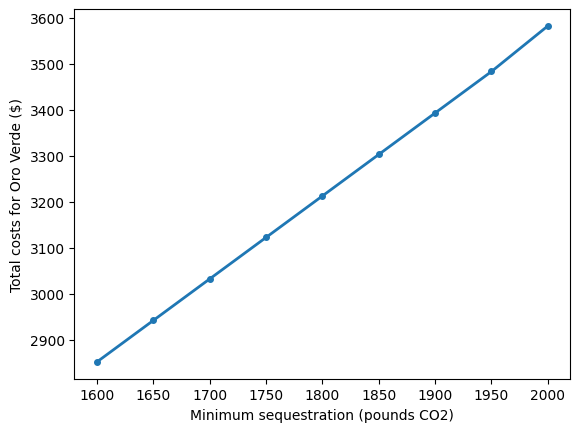

In [48]:
plt.plot(carbon_seq_values, all_cost_values, marker='o', linestyle='solid', linewidth=2, markersize=4)
plt.xlabel("Minimum sequestration (pounds CO2)")
plt.ylabel("Total costs for Oro Verde ($)")

Note that the dependency is actually __linear__! This is always the case in linear optimization problems when parameter changes occur in a limited range. (We will discuss what happens if we examined a wider range in class!)

We can actually calculate the slope of the line above:

In [49]:
print(f"The slope above is: {(all_cost_values[1]-all_cost_values[0])/(carbon_seq_values[1]-carbon_seq_values[0]):.4f}")

The slope above is: 1.8037


### Obtaining Sensitivity Information from Gurobi

The slope in the graph above actually bears a name in optimization: __shadow price__. More formally, __the shadow price of a constraint__ is the rate of change (i.e., slope) if you plotted the **optimal objective value** as a function on the **right-hand-side of one constraint**. Gurobi **calculates the shadow prices** as well the **allowable increase/decrease** range, which tells you for the range of changes in the right-hand-side within which the same shadow price value applies.

<font color=red>**To obtain the shadow price and allowable increase/decrease for a constraint `con` after solving the model, use:**</font>
 - <font color=red>`con.Pi` to recover the shadow price (at the current value of the constraint right-hand-side) </font>
 - <font color=red>`con.SARHSLow` to recover the smallest value of the right-hand-side for which the same shadow price applies</font>
 - <font color=red>`con.SARHSUp` to recover the largest value of the right-hand-side for which the same shadow price applies.</font>
  
To see this, let's first resolve our original model (with the sequestration commitment equal to 1,800).

In [50]:
# let's obtain the constraint corresponding to carbon seq
c = all_constr["carbon_seq"]

# reset the value to the original one
c.RHS = annual_seq_commit

# resolve the model
mymodel.optimize()

# get the shadow price and allowable increase-decrease
print(f"The shadow price for the carbon_seq constraint is {c.Pi:.4f}.")
print(f"This shadow price applies down to a value of {c.SARHSLow:.4f} and up to a value of {c.SARHSUp:.4f} for the RHS.")

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 7 rows, 3 columns and 13 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [3e+00, 5e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 2e+05]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.0945941e+03   6.905474e+03   0.000000e+00      0s
       1    3.2130952e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.213095170e+03
The shadow price for the carbon_seq constraint is 1.8037.
This shadow price applies down to a value of 92.5000 and up to a value of 1986.1086 for the RHS.


We can display this information nicely for all the constraints with the following code. This creates a DataFrame with all the relevant information and displays it.

In [51]:
# Create a data-frame to print everything
allConstraints = mymodel.getConstrs()

all_constr_data = [ [c.ConstrName, mymodel.getRow(c).getValue(), c.Sense, c.RHS, c.Slack, c.Pi, c.SARHSLow, c.SARHSUp ] \
                   for c in allConstraints ]

# convert into a dataframe and print
df = pd.DataFrame(all_constr_data, columns=["Constraint Name", "LHS Value", "Sense", "RHS Value", "Slack", "Shadow Price",\
                                           "Lower Limit RHS", "Upper Limit RHS"])
display(df)

,Constraint Name,LHS Value,Sense,RHS Value,Slack,Shadow Price,Lower Limit RHS,Upper Limit RHS
0,land_avail,150000.000000,<,150000.0,0.000000,-0.000223,1.303027e+05,1.829801e+06
1,water_avail,45282.439274,<,50000.0,4717.560726,0.000000,4.528244e+04,inf
2,Maple_seedlings,582.797656,<,1000.0,417.202344,0.000000,5.827977e+02,inf
3,Elm_seedlings,20.621196,<,500.0,479.378804,0.000000,2.062120e+01,inf
4,Spruce_seedlings,0.000000,<,1500.0,1500.000000,0.000000,0.000000e+00,inf
5,min_elms,20.621196,>,15.0,-5.621196,0.000000,-inf,2.062120e+01
6,carbon_seq,1800.000000,>,1800.0,0.000000,1.803667,9.250000e+01,1.986109e+03
